In [1]:
run readAcetone.py

Acetone/20220127_05_Acetone_Measurement_01_Tight_17O.txt
Acetone/20220127_06_Acetone_Measurement_02_Tight_17O.txt
Acetone/20220127_07_Acetone_Measurement_03_Tight_17O.txt
Acetone/20220127_08_Acetone_Measurement_04_Tight_17O.txt
Acetone/20220127_09_Acetone_Measurement_05_Tight_17O.txt
File 0 59 D/Unsub fails RSE/SN Test with value of 3.4444887840412424
File 1 59 D/Unsub fails RSE/SN Test with value of 2.395650167379506
File 2 59 D/Unsub fails RSE/SN Test with value of 2.44845796902032
File 3 59 D/Unsub fails RSE/SN Test with value of 2.820331491278589
File 4 59 D/Unsub fails RSE/SN Test with value of 3.2768950826460204
20220127_08_Acetone_Measurement_04_Tight_17O.txt D 59 has 1 zero scans, out of 8263 scans (0.00012102142079148009)
20220127_09_Acetone_Measurement_05_Tight_17O.txt D 59 has 1 zero scans, out of 4394 scans (0.0002275830678197542)
20220127_05_Acetone_Measurement_01_Tight_17O.txt 17O 59 has 21 zero scans, out of 6885 scans (0.0030501089324618735)
20220127_06_Acetone_Measurem

5it [00:08,  1.72s/it]
5it [00:11,  2.40s/it]
1it [00:01,  1.77s/it]

Failed Subsequence Detection 20220127_05_Acetone_Measurement_01_Tight_17O.txt 59 D with a value of 0.98


2it [00:03,  1.75s/it]

Failed Subsequence Detection 20220127_06_Acetone_Measurement_02_Tight_17O.txt 59 D with a value of 0.53


3it [00:05,  1.70s/it]

Failed Subsequence Detection 20220127_07_Acetone_Measurement_03_Tight_17O.txt 59 D with a value of 0.49


4it [00:08,  2.19s/it]

Failed Subsequence Detection 20220127_08_Acetone_Measurement_04_Tight_17O.txt 59 D with a value of 0.26


5it [00:09,  1.81s/it]


Failed Subsequence Detection 20220127_09_Acetone_Measurement_05_Tight_17O.txt 59 D with a value of 0.23


5it [00:11,  2.21s/it]
5it [00:07,  1.57s/it]
5it [00:00, ?it/s]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns

#we processed as 5 separate files; now join them together and properly adjust retTime and scanNumber
cretTime = 0
cscanN = 0
newList = []
#for each dataframe
for merged in mergedList:
    cDf = merged[0].copy()
    
    #update retTime, scanNumber
    cDf['retTime'] += cretTime
    cDf['scanNumber'] += cscanN
    
    cretTime = cDf['retTime'].max()
    cscanN = cDf['scanNumber'].max()
    
    newList.append(cDf)
    
#combine the dataframes
fullDf = pd.concat(newList, ignore_index=True)

100%|██████████| 100/100 [00:00<00:00, 954.98it/s]


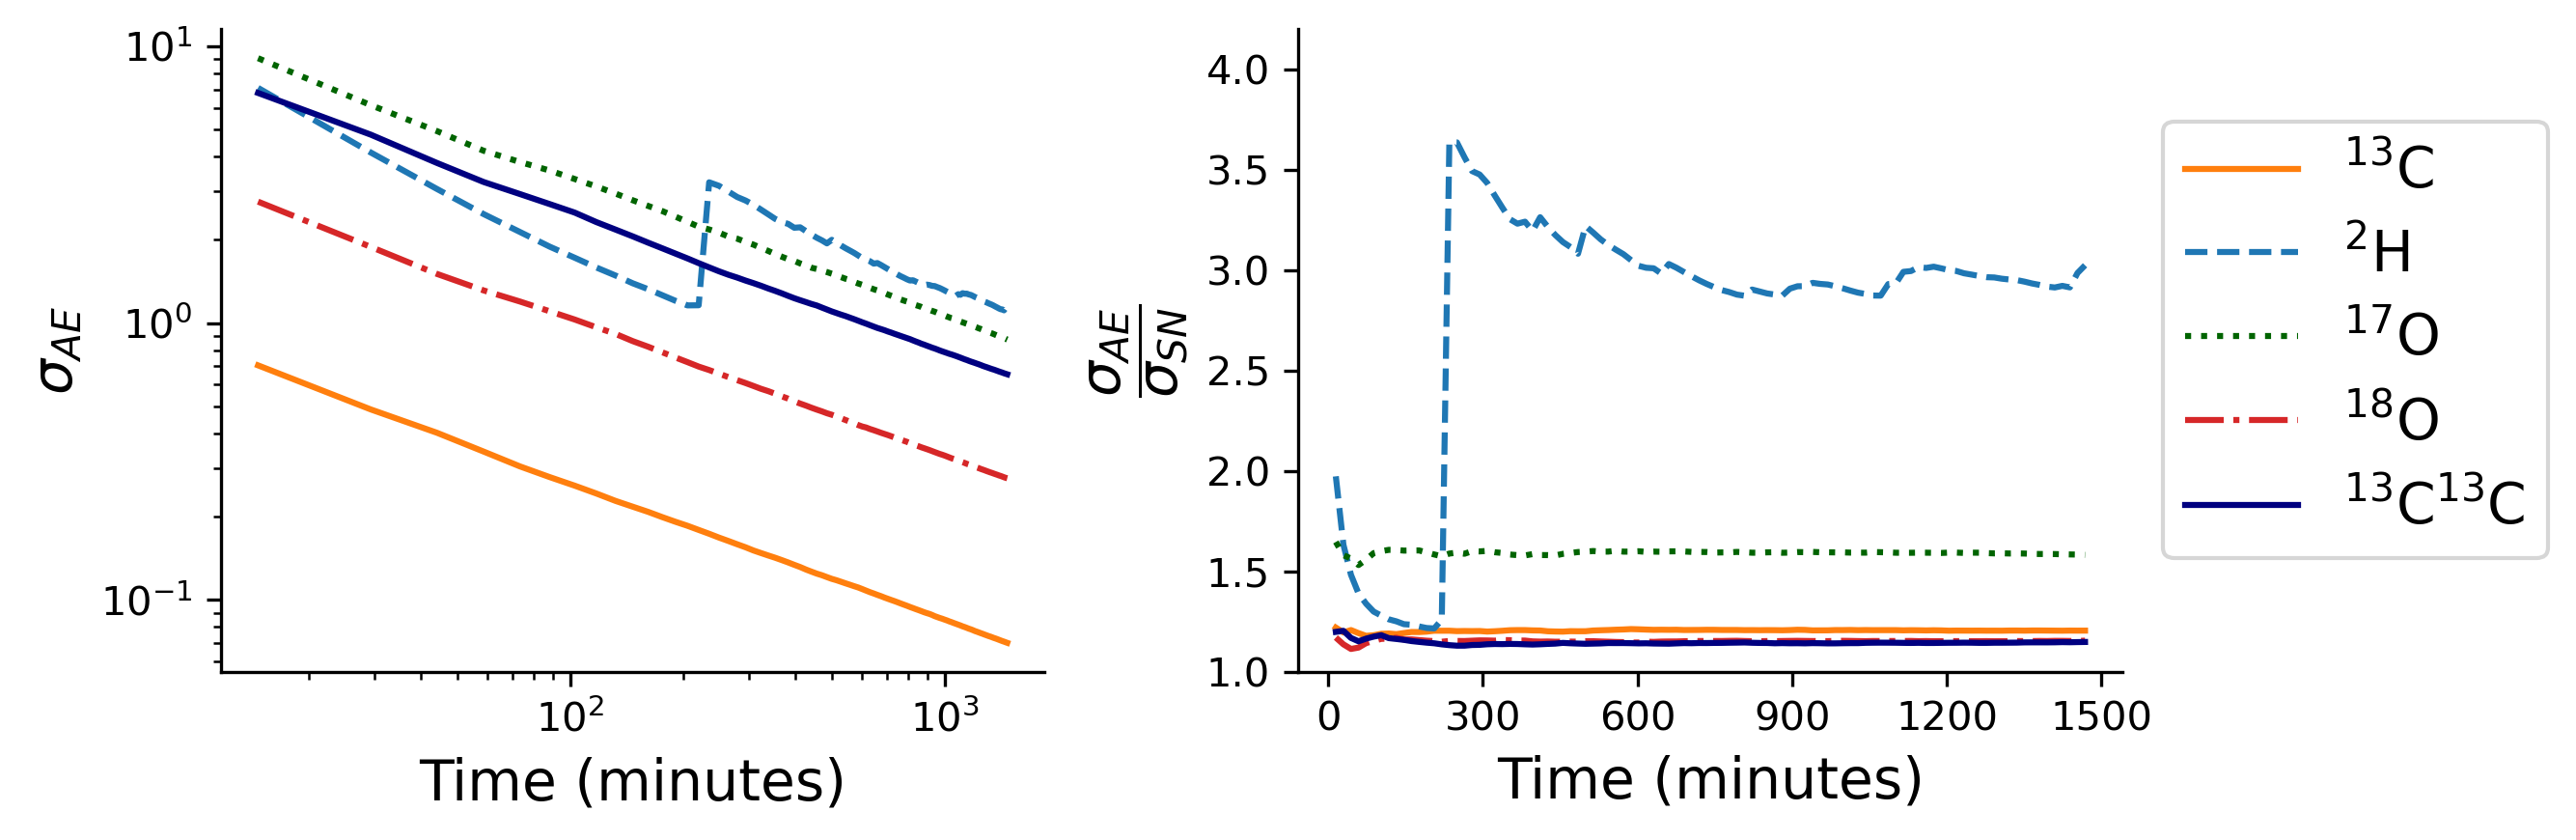

In [3]:
#Figure in the paper
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3), dpi = 300)

#set parameters for the plot
markers = ['o','s','^','*','H']
colors = ['tab:orange','tab:blue','darkgreen','tab:red','navy']
labels = ["$^{13}$C",'$^{2}$H','$^{17}$O','$^{18}$O','$^{13}$C$^{13}$C']
linestyles = ['-','--',':','dashdot','-']

#For each ratio
for rIdx, targetRat in enumerate(['13C/Unsub','D/Unsub','17O/Unsub','18O/Unsub','13C-13C/Unsub']):
    sub1, sub2 = targetRat.split('/')

    #select the timeseries for this ratio
    series = fullDf[targetRat]

    #calculate RSE and SN at nIter timepoints and append to a list; here initialize the lists
    nIter= 100
    l = len(series)
    means = []
    serrs = []
    nscans = []
    SN = []
    RSE = []
    predictedPrec = []
    times = []

    #for each iteration
    for i in tqdm(range(nIter)):
        #maxscan tells you how far to go in the series
        maxscan = (i+1) * l //nIter

        current = fullDf[:maxscan]
        nscans.append(maxscan)

        #calculate current mean, standard error
        cmean = current[sub1 + '/' + sub2].mean()
        cserr = current[sub1 + '/' + sub2].std() / np.sqrt(maxscan)
        Rserr = cserr / cmean
        RSE.append(Rserr)
        means.append(cmean)
        serrs.append(cserr)
        times.append(current['retTime'].max())

        #calculate current shot noise
        cCounts18O = current['counts' + sub1].sum()
        cCounts34S = current['counts' + sub2].sum()

        cSN =  np.power((1./cCounts18O + 1./cCounts34S), 0.5)
        SN.append(cSN)

    #begin plotting; first the left plot, acquisition error vs time
    cAx = axes[0]
    cAx.set_yscale("log", nonpositive='clip')
    cAx.set_xscale("log", nonpositive='clip')

    #plot
    cAx.plot(times, np.array(RSE)*1000, label = labels[rIdx],
                color = colors[rIdx], linestyle = linestyles[rIdx])

    #label the xs at specific target times
    xtickTargetsInMin = [0,300,600,900,1200,1500]
    #retTime per scan/scanNumber per iteration
    xtick = [x / (0.04378702 * fullDf['scanNumber'].max() / nIter)  for x in xtickTargetsInMin]
    xtickLab = [str(x) for x in xtickTargetsInMin]
    
    #Labels
    cAx.set_xlabel("Time (minutes)", fontsize = 14)
    cAx.set_ylabel("$\sigma_{AE}$",fontsize = 14)

    sns.despine()

    #Right plot; acquisition error vs SN ratio
    cAx = axes[1]
    #calculate ratio
    ratio = np.array(RSE)/np.array(SN)
    #plot
    cAx.plot(range(1,len(ratio)+1),ratio, color = colors[rIdx], label = labels[rIdx], linestyle = linestyles[rIdx])
    #set labels and limits
    cAx.set_ylabel(r'$\dfrac{\sigma_{AE}}{\sigma_{SN}}$', fontsize = 14)
    cAx.set_xlabel("Time (minutes)", fontsize = 14)
    cAx.set_ylim(1,4.2)
    
    #add legend, xticks
    cAx.legend(loc = 'upper right', bbox_to_anchor=(1.55,0.9), fontsize = 14)
    cAx.set_xticks(xtick)
    cAx.set_xticklabels(xtickLab)
    sns.despine()

    plt.tight_layout()

fig.savefig("Shot Noise Limits All Unsub Acetone.jpg", dpi = 1000)